# MCMC heavy case, again

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import pandas as pd

import seaborn as sns
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters, likelihood_levels_1d
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot
from ctau_utils import ctau_heavy
from analyses_dict import analyses
from const import alphaQED
from likelihood_contours_plot import set_plot_style, set_canvas_basic, set_plot_title, plot_data_from_analysis

In [3]:
from mcmc_utils import heavy_nonminimal_mcmc

from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [5]:
hierarchy = 'heavy'
D_or_M = 'dirac'

set_backend = True
reset_backend = False
n_samples = 20000

spec = 'nominimal p0d only logs'

set_plot_style()

In [6]:
this_dark_nus_mcmc = heavy_nonminimal_mcmc(hierarchy, D_or_M, title_addition=spec)

heavy dirac FHC
Wall time: 0.5905394554138184 s, CPU time: 0.5787453609999993
heavy dirac RHC
Wall time: 0.5752866268157959 s, CPU time: 0.5643614010000011


In [7]:
this_dark_nus_mcmc.exp_analysis_objs

{'heavy_dirac_FHC': <exp_analysis_class.exp_analysis at 0x2acb2f435a90>,
 'heavy_dirac_RHC': <exp_analysis_class.exp_analysis at 0x2acafd314820>}

# Prepare the dataset to minimize computation

In [8]:
tpc_analysis = analyses['tpc']

In [9]:
basic_weights = {}
for nu_mode in ['FHC', 'RHC']:
    exp_analysis = this_dark_nus_mcmc.exp_analysis_objs[f'{hierarchy}_{D_or_M}_{nu_mode}']
    exp_analysis.df_base = exp_analysis.df_base.query(tpc_analysis['FHC']['selection'] + ' & (~argon)')
    # exp_analysis.df_base = exp_analysis.df_base.query(tpc_analysis['FHC']['selection'])
    aux_weights = deepcopy(exp_analysis.df_base['generator_weight'])
    aux_weights /= exp_analysis.Vmu4_alpha_epsilon2
    aux_weights *= exp_analysis.compute_pot_ntarget_weights(exp_analysis.df_base, 
                                                            tpc_analysis[nu_mode]['n_target'], 
                                                            tpc_analysis[nu_mode]['pot'])
    aux_weights *= tpc_analysis[nu_mode]['efficiency']
    basic_weights[nu_mode] = aux_weights

In [10]:
ndim = 4
def heavy_posterior(parameters):
    '''Posterior in the heavy minimal model with no geometry: parameters = [log10_m4, log10_mz, log10_Vmu4_alpha_epsilon2, log10_Valpha4_alpha_epsilon2]
       It uses global pars to speed up parallel computation'''
    actual_m4 = 10**parameters[0]
    actual_mz = 10**parameters[1]
    actual_Vmu4_alpha_epsilon2 = 10**parameters[2]
    actual_Valpha4_alpha_epsilon2 = 10**parameters[3]
    if (actual_m4 < this_dark_nus_mcmc.m4_limits[0]) or\
       (actual_m4 > this_dark_nus_mcmc.m4_limits[1]) or\
       (actual_mz < this_dark_nus_mcmc.mz_limits[0]) or\
       (actual_mz > this_dark_nus_mcmc.mz_limits[1]) or\
       (actual_m4 >= actual_mz) or\
       (actual_Vmu4_alpha_epsilon2 <= this_dark_nus_mcmc.lower_bound_Vmu4_alpha_epsilon2) or\
       (actual_Vmu4_alpha_epsilon2 > this_dark_nus_mcmc.upper_bound_Vmu4_alpha_epsilon2) or\
       (actual_Valpha4_alpha_epsilon2 < actual_Vmu4_alpha_epsilon2) or\
       (actual_Valpha4_alpha_epsilon2 > this_dark_nus_mcmc.upper_bound_Valpha4_alpha_epsilon2):
        return -np.inf, -np.inf, -np.inf, -np.inf
    else:
        like = 0
        mu = 0
        sigma2 = 0
        ctau = ctau_heavy(actual_m4, 
                          actual_mz, 
                          actual_Valpha4_alpha_epsilon2, 
                          this_dark_nus_mcmc.D_or_M)
        for nu_mode in ['FHC', 'RHC']:
            this_analysis = this_dark_nus_mcmc.exp_analysis_objs[f'{hierarchy}_{D_or_M}_{nu_mode}']
            this_weights = this_analysis.kde_on_a_point(this_analysis.df_base, 
                                          (actual_m4, actual_mz))
            this_weights *= this_analysis.compute_ctau_integral_weights(this_analysis.df_base, ctau)
            this_weights *= basic_weights[nu_mode]
            this_weights *= actual_Vmu4_alpha_epsilon2
            out = this_analysis.compute_likelihood(
                    this_analysis.df_base, 
                    this_weights, 
                    analysis=tpc_analysis[nu_mode], 
                    like_normalized=False)
            like += out[0]
            mu += out[1]
            sigma2 += out[3]
        return like, mu, sigma2, ctau

labels = ['log10_m4', 'log10_mz', 'log10_Vmu4_alpha_epsilon2', 'log10_Valpha4_alpha_epsilon2']
blobs_dtype = [('mu', float), ('sigma2', float), ('ctau', float)]

In [12]:
Vmu4_alphaepsilon2_bp = physics_parameters['heavy']['bp']['Umu4_2']*\
                           physics_parameters['heavy']['bp']['alpha_dark']*\
                           alphaQED*physics_parameters['heavy']['bp']['epsilon']**2

Valpha4_alphaepsilon2_bp = physics_parameters['heavy']['bp']['Ud4_2']*\
                           physics_parameters['heavy']['bp']['alpha_dark']*\
                           alphaQED*physics_parameters['heavy']['bp']['epsilon']**2

In [13]:
Vmu4_alphaepsilon2_bp

2.953968320041556e-13

In [14]:
heavy_posterior([np.log10(0.1), np.log10(1.25), np.log10(Vmu4_alphaepsilon2_bp), np.log10(Valpha4_alphaepsilon2_bp)])

(-7.877566124274658, 7.93258364591984, 2.304904240005982, 0.5410463601562198)

In [15]:
heavy_posterior([np.log10(0.1), np.log10(0.5), np.log10(Vmu4_alphaepsilon2_bp), np.log10(2*Valpha4_alphaepsilon2_bp)])

(-0.5940243928540401,
 8.005190595272764e-09,
 0.012687760163261466,
 0.006758730867366077)

In [16]:
this_dark_nus_mcmc.set_posterior(heavy_posterior, 
                                 ndim, 
                                 labels=labels)

In [18]:
with Pool() as pool:
    this_dark_nus_mcmc.initialise_mcmc(ndim**2, pool,
                                       set_backend=set_backend, reset_backend=reset_backend, 
                                       blobs_dtype=blobs_dtype, log_ms=True)
    # this_dark_nus_mcmc.run_mcmc(n_samples)

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [       nan        nan 0.61766249 0.64372882]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [1.0897959       nan       nan       nan]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [1.13088206 1.26730488 0.96935115 1.33282775]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [1.54363667 1.67802695 1.92661182 1.87004031]
The chain is

(100, 16, 4)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


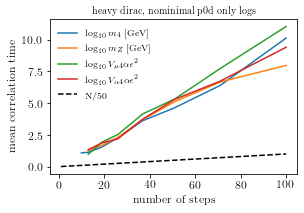

In [19]:
this_dark_nus_mcmc.compute_autocorrelation_time(store=True)

In [18]:
this_dark_nus_mcmc.get_samples(discard=0, thin=1)

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.13405322  7.97643836 11.04330495  9.40717274]
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<Figure size 1080x504 with 5 Axes>,
 array([<AxesSubplot:ylabel='$\\log_{10}m_4$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}m_Z$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}V_{\\mu 4}\\alpha \\epsilon^2$'>,
        <AxesSubplot:ylabel='$\\log_{10}V_{\\alpha 4}\\alpha \\epsilon^2$'>,
        <AxesSubplot:xlabel='step number', ylabel='log(p)'>], dtype=object))

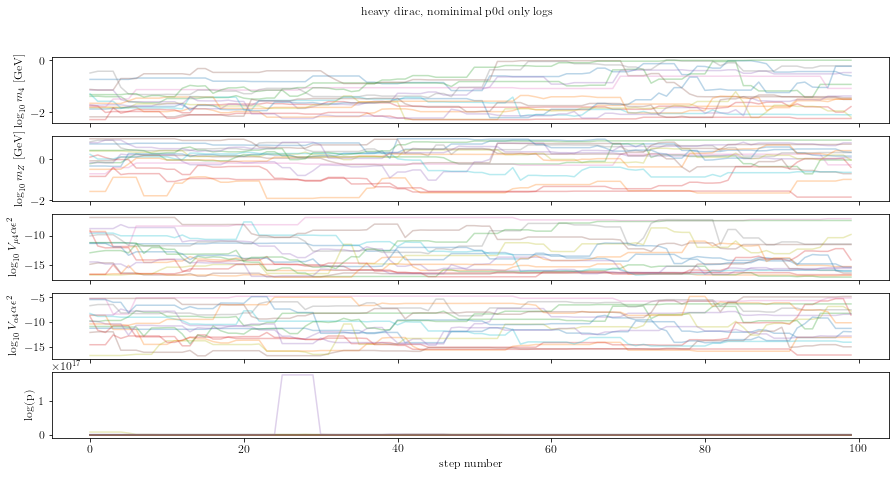

In [19]:
this_dark_nus_mcmc.plot_chains(store=True)

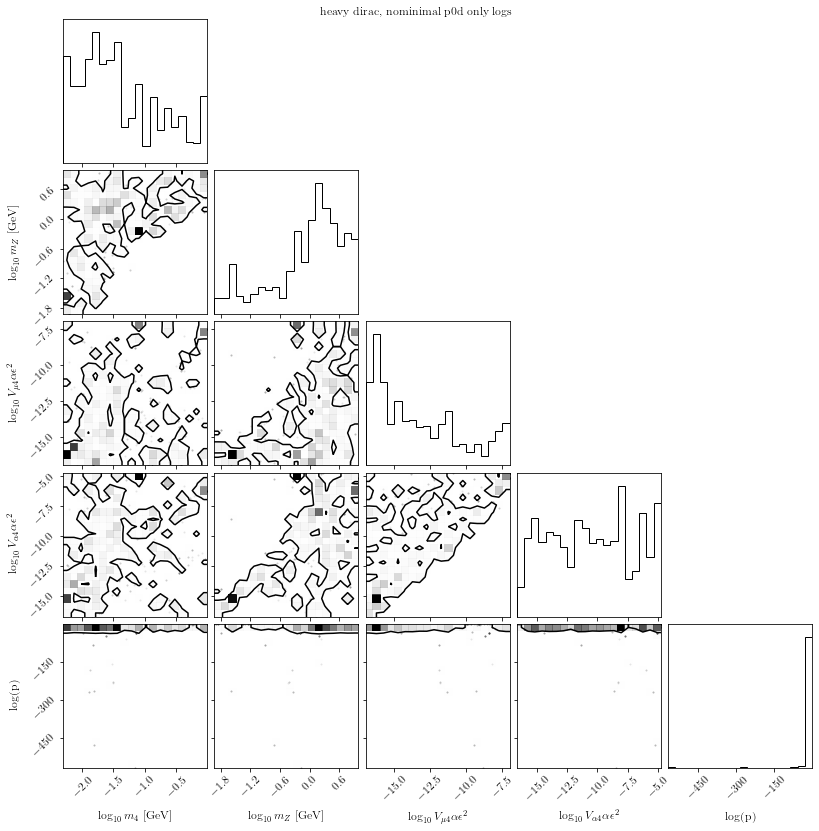

In [20]:
this_dark_nus_mcmc.corner_plot_raw(savefile='raw_corner')

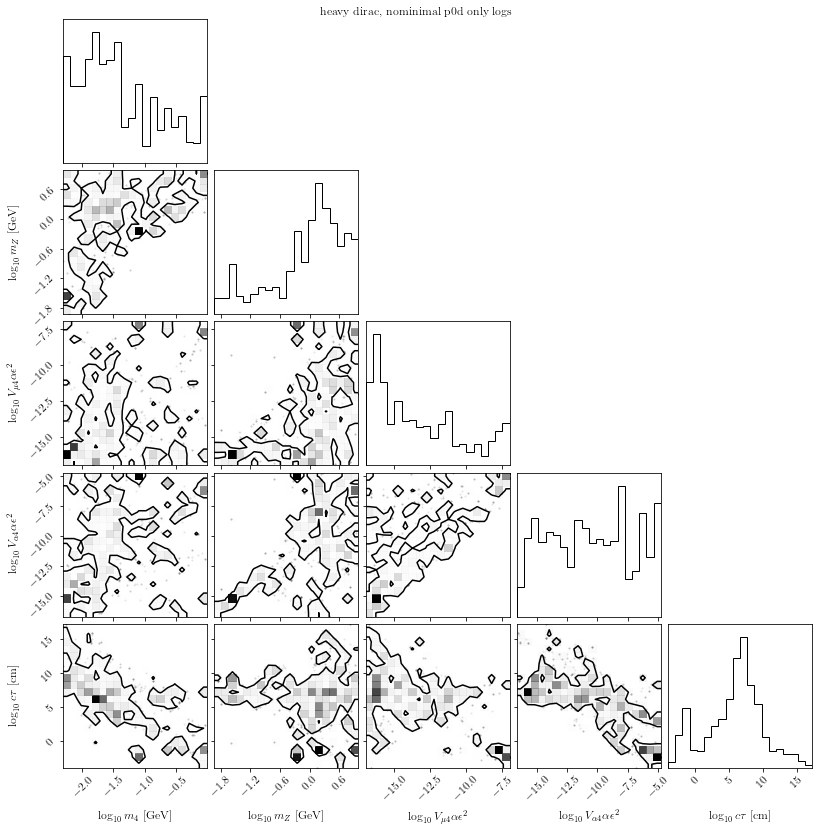

In [21]:
this_dark_nus_mcmc.corner_plot_physics(savefile='physics_corner')

In [22]:
print('Fraction of samples with null expectation =', (this_dark_nus_mcmc.samples['mu'] == 0).sum()/len(this_dark_nus_mcmc.samples))

Fraction of samples with null expectation = 0.006875


/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:409: RuntimeWarning: invalid value encountered in subtract
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:763: RuntimeWarning: invalid value encountered in subtract
  return [self.samples[:, i] - means[i] for i in range(pars)]


Removed no burn in


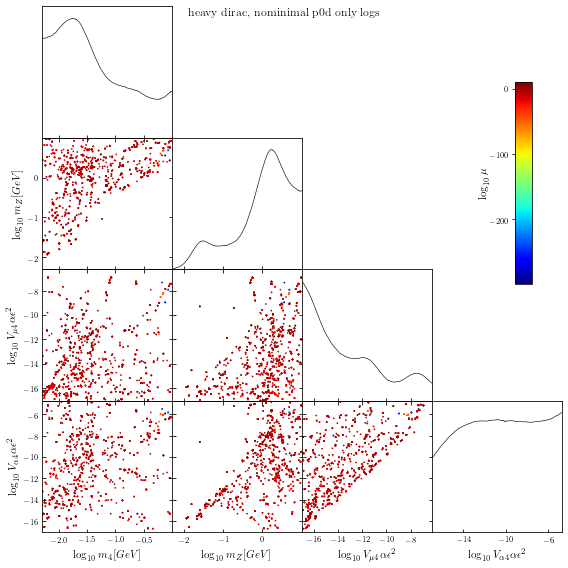

In [23]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_mu', savefile='corner_log10_mu')

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:409: RuntimeWarning: invalid value encountered in subtract
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:763: RuntimeWarning: invalid value encountered in subtract
  return [self.samples[:, i] - means[i] for i in range(pars)]


Removed no burn in


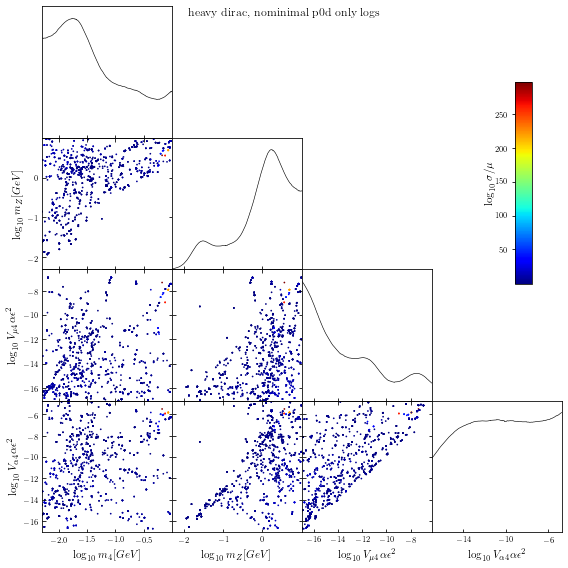

In [24]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_sigma/mu', savefile='corner_log10_sigma_mu')

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:409: RuntimeWarning: invalid value encountered in subtract
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:763: RuntimeWarning: invalid value encountered in subtract
  return [self.samples[:, i] - means[i] for i in range(pars)]


Removed no burn in


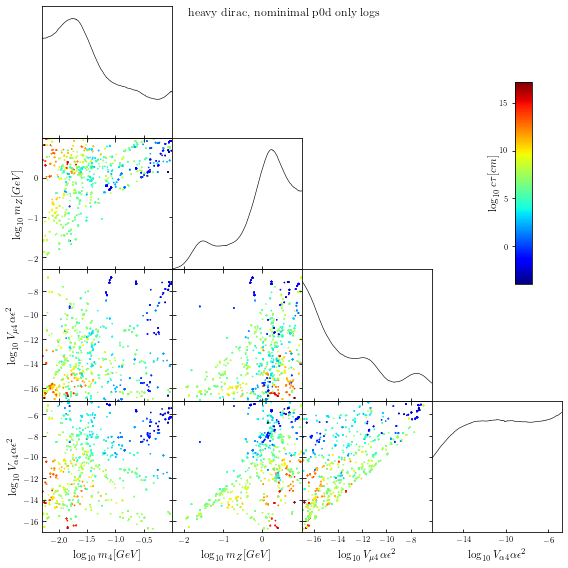

In [25]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_ctau', savefile='corner_log10_ctau')

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:409: RuntimeWarning: invalid value encountered in subtract
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:763: RuntimeWarning: invalid value encountered in subtract
  return [self.samples[:, i] - means[i] for i in range(pars)]


Removed no burn in


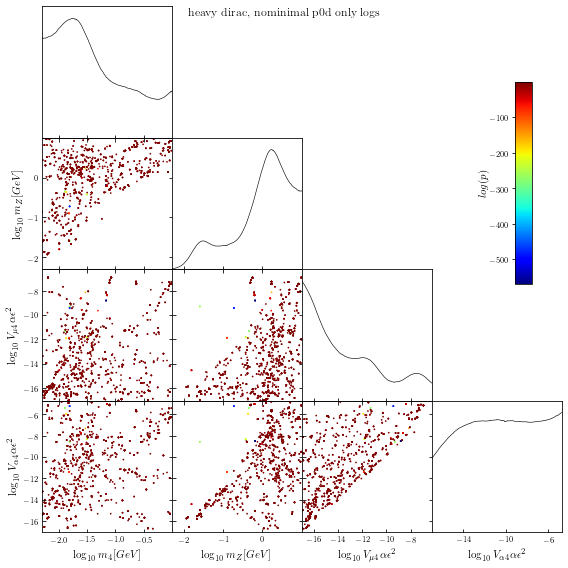

In [26]:
this_dark_nus_mcmc.corner_plot_with_colour('log(p)', savefile='corner_log10_ctau')